# Test: the impact of an AGN power-law continuum
---
What effect do emission lines have upon the recovery of the mass-weighted age of the stellar population? In this notebook, we will look at the effects of 
* emission lines vs. no emission lines;
* broad emission lines vs. narrow emission lines;
* complex, multi-component emission lines vs. simple single-component emission lines
upon the derived mass-weighted age.

In [1]:
%matplotlib widget

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
display(HTML("<style>.output_result { max-width:75% !important; }</style>"))

In [1]:
import numpy as np
from numpy.random import RandomState
from time import time 
from tqdm.notebook import tqdm
import multiprocessing

from astropy.io import fits

from ppxftests.run_ppxf import run_ppxf
from ppxftests.ssputils import load_ssp_templates
from ppxftests.mockspec import create_mock_spectrum, calculate_mw_age
from ppxftests.ppxf_plot import plot_sfh_mass_weighted

import matplotlib.pyplot as plt
plt.ion()
plt.close("all")

from IPython.core.debugger import Tracer

### Defining the AGN continuum
---
In this work, we approximate the AGN continuum as a simple power law,

$$F_{\rm AGN}(\lambda) = F_0 \lambda^{-\alpha_{\lambda}}$$

where the exponent $\alpha_{\lambda} = 2 -\alpha_{\nu}$ where $\alpha_{\nu}$ can range from 1.2 - 2.0 (Groves et al. 2004). 

To determine reasonable values for $F_0$, we use the tight correlation between the total H$\beta$ luminosity, $L_{\rm H\beta}$, and $L_{\rm NT}$, which is defined as the total luminosity of the AGN continuum between 3000 Å and 9500 Å (Neugebauer et al. 1979, Yee 1980), i.e.,

$$L_{\rm NT} = \int^{9500\,Å}_{3000\,Å} F_{\rm AGN}(\lambda) d\lambda 
= \int^{9500\,Å}_{3000\,Å} F_0 \lambda^{-\alpha_{\lambda}} d\lambda 
= \frac{F_0}{1 - \alpha_\lambda}\left(9500^{1 - \alpha_\lambda} - 3000^{1 - \alpha_\lambda} \right)$$

where $F_{\rm AGN}(\lambda)$ is the AGN continuum. In a sample of AGN including quasars, broad & narrow-line radio galaxies and Seyfert 1 & 2 galaxies, Yee (1980) observed a tight correlation such that 

$$\log_{10} L_{\rm NT} \approx \log_{10} L_{\rm H\beta} - 2$$

We therefore use our adopted $L_{\rm H\beta}$ in the emission lines to constrain the strength of the AGN continuum in our mock spectra, so that 

$$ F_0 = \frac{0.01L_{\rm H\beta}({1 - \alpha_\lambda})}{\left(9500^{1 - \alpha_\lambda} - 3000^{1 - \alpha_\lambda} \right)} $$



In [ ]:
###########################################################################
# Defining the AGN continuum using the method of Yee 1980
###########################################################################



In [2]:
###########################################################################
# Settings
###########################################################################
isochrones = "Padova"
SNR = 100
sigma_star_kms = 250
z = 0.01

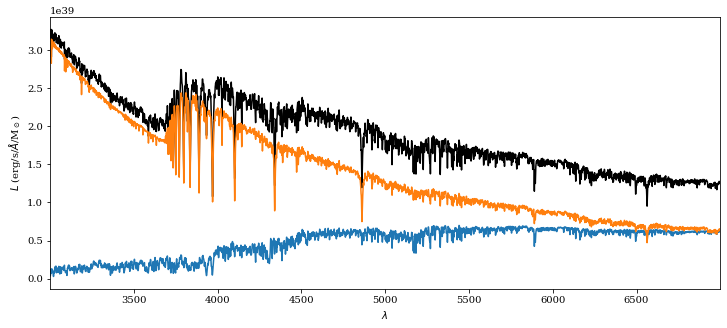

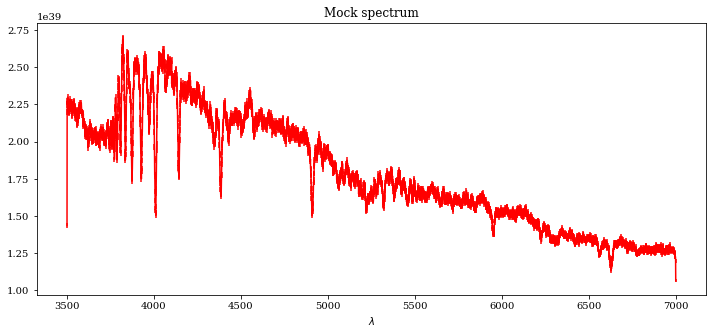

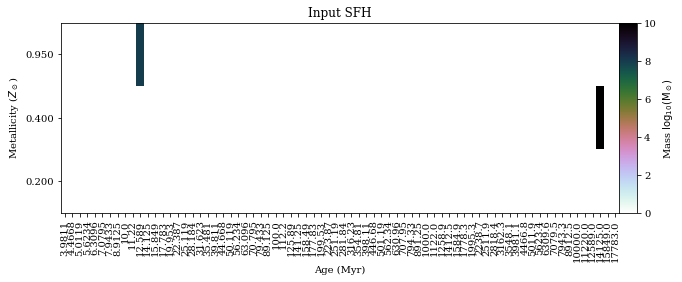

In [12]:
###########################################################################
# Generate the input SFH
###########################################################################
# Load the stellar templates so we can get the age & metallicity dimensions
_, _, metallicities, ages = load_ssp_templates(isochrones)
N_ages = len(ages)
N_metallicities = len(metallicities)

# Simple Gaussian SFH
xx, yy = np.meshgrid(range(N_ages), range(N_metallicities))
x0 = 15
y0 = 2.5
sigma_x = 4
sigma_y = 0.1
sfh_young = np.exp(- (xx - x0)**2 / (2 * sigma_x**2)) *\
               np.exp(- (yy - y0)**2 / (2 * sigma_y**2))
sfh_young /= np.nansum(sfh_young)
sfh_mw_young = sfh_young * 1e8

x0 = 60
y0 = 4
sigma_x = 5
sigma_y = 0.5
sfh_old = np.exp(- (xx - x0)**2 / (2 * sigma_x**2)) *\
             np.exp(- (yy - y0)**2 / (2 * sigma_y**2))
sfh_old /= np.nansum(sfh_old)
sfh_mw_old = sfh_old * 1e10

# Add the young & old components
sfh_mw_original = sfh_mw_old + sfh_mw_young

# Instead of a Gaussian SFH, try with a "delta function" SFH (i.e., 1 old & 1 young template)
sfh_mw_original = np.zeros((N_metallicities, N_ages))
# sfh_mw_original[2, 4] = 0.5e7
# sfh_mw_original[1, 4] = 1.5e7
sfh_mw_original[2, 10] = 1e8
sfh_mw_original[1, -3] = 1e10

sfh_mw_1D_original = np.nansum(sfh_mw_original, axis=0)

# Compute the mean mass-weighted age below 1 Gyr
log_age_mw_original, log_age_mw_original_idx = calculate_mw_age(sfh_mw_original, age_thresh=1e9, ages=ages)

# Create the spectrum here, just so we can check it looks OK
spec_nolines, spec_nolines_err, lambda_vals_A = create_mock_spectrum(
    sfh_mass_weighted=sfh_mw_original,
    isochrones=isochrones, z=z, SNR=SNR, sigma_star_kms=sigma_star_kms,
    plotit=True)



In [14]:
# Helper function for multiprocessing
def ppxf_helper(args):
    # Unpack arguments
    seed, spec, spec_err, lambda_vals_A = args
    
    # Add "extra" noise to the spectrum
    rng = RandomState(seed)
    noise = rng.normal(scale=spec_err)
    spec_noise = spec + noise

    # This is to mitigate the "edge effects" of the convolution with the LSF
    spec_noise[0] = -9999
    spec_noise[-1] = -9999

    # Run ppxf
    pp = run_ppxf(spec=spec_noise, spec_err=spec_err, lambda_vals_A=lambda_vals_A,
                  z=z, ngascomponents=1,
                  regularisation_method="none", 
                  isochrones="Padova",
                  fit_gas=False, tie_balmer=True,
                  plotit=False, savefigs=False, interactive_mode=False)
    return pp

# Helper function so that we can run ppxf on different inputs.
def helper_fn(spec, spec_err, lambda_vals_A,
              niters=100, nthreads=20, ngascomponents=1):  

    ###########################################################################
    # Run ppxf WITHOUT regularisation, using a MC approach
    ###########################################################################
    # Input arguments
    seeds = list(np.random.randint(low=0, high=100 * niters, size=niters))
    args_list = [[s, spec, spec_err, lambda_vals_A] for s in seeds]

    # Run in parallel
    print(f"Running ppxf on {nthreads} threads...")
    t = time()
    with multiprocessing.Pool(nthreads) as pool:
        pp_list = list(tqdm(pool.imap(ppxf_helper, args_list), total=niters))
    print(f"Elapsed time in ppxf: {time() - t:.2f} s")

    ###########################################################################
    # Run ppxf WITH regularisation
    ###########################################################################
    t = time()
    pp_regul = run_ppxf(spec=spec, spec_err=spec_err, lambda_vals_A=lambda_vals_A,
                        z=z, ngascomponents=ngascomponents,
                        regularisation_method="auto",
                        isochrones="Padova",
                        fit_gas=False, tie_balmer=True,
                        delta_regul_min=1, regul_max=5e4, delta_delta_chi2_min=5,
                        plotit=False, savefigs=False, interactive_mode=False)
    print(f"Total time in run_ppxf: {time() - t:.2f} seconds")

    ###########################################################################
    # Compute the mass-weighted age 
    ###########################################################################
    log_age_mw_regul, log_age_mw_regul_idx = calculate_mw_age(pp_regul.weights_mass_weighted, age_thresh=1e9, ages=ages)

    log_age_mw_list = []
    for pp in pp_list:
        log_age_mw, _ = calculate_mw_age(pp.weights_mass_weighted, age_thresh=1e9, ages=ages)
        log_age_mw_list.append(log_age_mw)

    log_age_mw_MC = np.nanmean(log_age_mw_list)
    log_age_mw_MC_err = np.nanstd(log_age_mw_list)
    # For plotting purposes, figure out the approx. index of these ages in the age array
    log_age_mw_MC_idx = (log_age_mw_MC - np.log10(ages[0])) / (np.log10(ages[1]) - np.log10(ages[0]))
    log_age_mw_MC_err_idx = log_age_mw_MC_err / (np.log10(ages[1]) - np.log10(ages[0]))

    print("------------------------------------------------------------")
    print(f"MC method:    mean mass-weighted age (log yr) = {np.nanmean(log_age_mw_list):.2f} ± {np.nanstd(log_age_mw_list):.2f}")
    print(f"Regul method: mean mass-weighted age (log yr) = {log_age_mw_regul:.2f}")
    print(f"Input value:  mean mass-weighted age (log yr) = {log_age_mw_original:.2f})")
    print("------------------------------------------------------------")

    ###########################################################################
    # COMPARE THE INPUT AND OUTPUT
    ###########################################################################
    sfh_fit_mw_list = []
    sfh_fit_lw_list = []
    sfh_fit_mw_1D_list = []
    sfh_fit_lw_1D_list = []

    for pp in pp_list:
        sfh_fit_mw_list.append(pp.weights_mass_weighted)
        sfh_fit_lw_list.append(pp.weights_light_weighted)
        sfh_fit_mw_1D_list.append(np.nansum(pp.weights_mass_weighted, axis=0))
        sfh_fit_lw_1D_list.append(np.nansum(pp.weights_light_weighted, axis=0))

    # Compute the mean SFH 
    sfh_fit_mw_mean = np.nansum(np.array(sfh_fit_mw_list), axis=0) / len(sfh_fit_mw_list)
    sfh_fit_lw_mean = np.nansum(np.array(sfh_fit_lw_list), axis=0) / len(sfh_fit_lw_list)
    sfh_fit_mw_1D_mean = np.nansum(sfh_fit_mw_mean, axis=0)
    sfh_fit_lw_1D_mean = np.nansum(sfh_fit_lw_mean, axis=0)

    sfh_fit_mw_1D_regul = np.nansum(pp_regul.weights_mass_weighted, axis=0)
    sfh_fit_lw_1D_regul = np.nansum(pp_regul.weights_light_weighted, axis=0)

    # Plot the mass-weighted weights, summed over the metallicity dimension
    for log_scale in [True]:
        # Create new figure 
        fig = plt.figure(figsize=(13, 4))
        ax = fig.add_axes([0.1, 0.2, 0.7, 0.7])
        ax.set_title(f"Mass-weighted template weights (SNR = {SNR:d})")

        # Plot the SFHs from each ppxf run, plus the "truth" SFH
        ax.fill_between(range(N_ages), sfh_mw_1D_original, step="mid", alpha=1.0, color="cornflowerblue", label="Input SFH")
        for jj in range(niters):
            ax.step(range(N_ages), sfh_fit_mw_1D_list[jj], color="pink", alpha=0.2, where="mid", linewidth=0.25, label="ppxf fits (MC simluations)" if jj == 0 else None)
        ax.step(range(N_ages), sfh_fit_mw_1D_mean, color="red", where="mid", label="Mean ppxf fit (MC simulations)")
        ax.step(range(N_ages), sfh_fit_mw_1D_regul, color="lightgreen", where="mid", label="ppxf fit (regularised)")

        # Plot horizontal error bars indicating the mean mass-weighted age from (a) the MC simulations and (b) the regularised fit 
        y = 10**(0.9 * np.log10(ax.get_ylim()[1])) if log_scale else 0.9 * ax.get_ylim()[1]
        ax.errorbar(x=log_age_mw_regul_idx, y=y, xerr=0, yerr=0, 
                    marker="D", mfc="lightgreen",mec="lightgreen",  ecolor="lightgreen",  
                    label="MW age ($< 1$ Gyr) (regularised fit)")
        ax.errorbar(x=log_age_mw_MC_idx, y=y, xerr=log_age_mw_MC_err_idx, yerr=0, 
                    marker="D", mfc="red", mec="red", ecolor="red",
                    label="MW age ($< 1$ Gyr) (MC simulations)")
        ax.errorbar(x=log_age_mw_original_idx, y=y, xerr=0, yerr=0, 
                    marker="D", mfc="cornflowerblue", mec="cornflowerblue", ecolor="cornflowerblue", 
                    label="MW age ($< 1$ Gyr) (input)")

        # Decorations 
        ax.set_xticks(range(N_ages))
        ax.set_xlabel("Age (Myr)")
        ax.set_xticklabels(["{:}".format(age / 1e6) for age in ages], rotation="vertical", fontsize="x-small")
        ax.autoscale(axis="x", enable=True, tight=True)
        ax.set_ylim([1, None])
        ax.set_ylabel(r"Template weight ($\rm M_\odot$)")
        ax.legend(fontsize="x-small", loc="center left", bbox_to_anchor=(1.01, 0.5))
        ax.set_xlabel("Age (Myr)")
        ax.set_yscale("log") if log_scale else None
        

Running ppxf on 20 threads...



Elapsed time in ppxf: 178.53 s
----------------------------------------------------
Iteration 0: Elapsed time in PPXF (single thread): 3.08 s
----------------------------------------------------
Iteration 1: Scaling noise by 1.4866...
Iteration 1: Running ppxf on 20 threads...
Iteration 1: Elapsed time in PPXF (multithreaded): 69.60 s
Iteration 1: optimal regul = 0.00; Δm = 0.201392; Δregul = 500.00 (Δregul_min = 1.00); Δχ (goal) - Δχ = 95.079
----------------------------------------------------
Iteration 2: Re-running ppxf on 20 threads (iteration 2)...
Iteration 2: Elapsed time in PPXF (multithreaded): 56.03 s
Iteration 2: optimal regul = 100.00; Δm = 2.00476e+10; Δregul = 100.00 (Δregul_min = 1.00); Δχ (goal) - Δχ = 28.967
----------------------------------------------------
Iteration 3: Re-running ppxf on 20 threads (iteration 3)...
Iteration 3: Elapsed time in PPXF (multithreaded): 59.73 s
Iteration 3: optimal regul = 60.00; Δm = 1.729e+09; Δregul = 20.00 (Δregul_min = 1.00); Δχ 

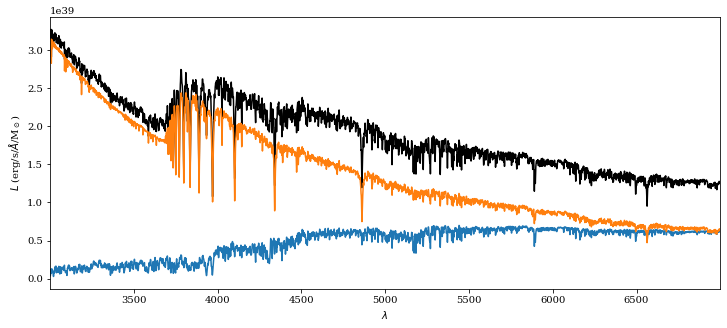

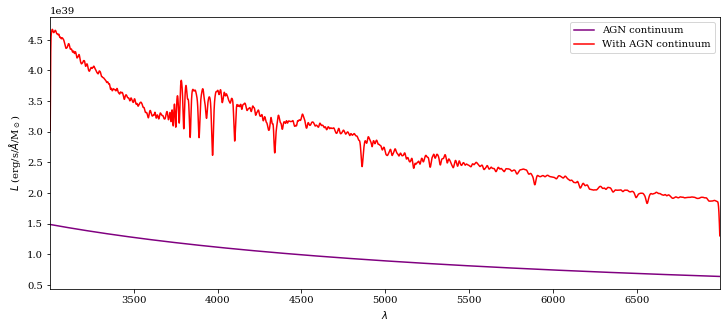

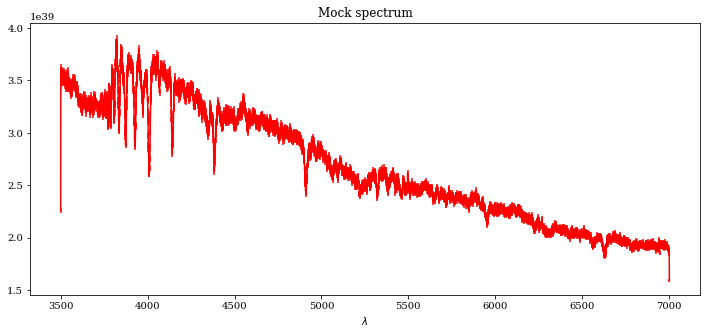

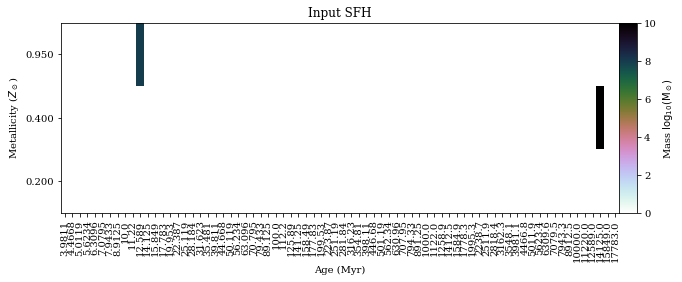

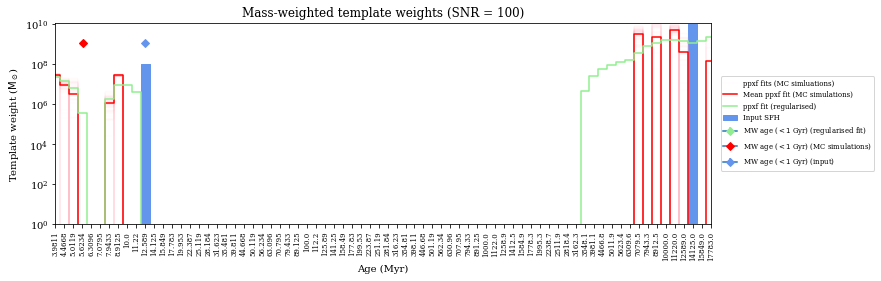

In [15]:
###########################################################################
# Case 1: AGN power law continuum, no emission lines
###########################################################################
spec_agn, spec_agn_err, lambda_vals_A = create_mock_spectrum(
    sfh_mass_weighted=sfh_mw_original,
    agn_continuum=True, agn_frac=0.5, alpha_nu=1.0,
    isochrones=isochrones, z=z, SNR=SNR, sigma_star_kms=sigma_star_kms,
    plotit=True)

helper_fn(spec_agn, spec_agn_err, lambda_vals_A, niters=100, nthreads=20, ngascomponents=1)

In [22]:
###########################################################################
# Case 2: narrow emission lines
###########################################################################
spec_narrowlines, spec_narrowlines_err, lambda_vals_A = create_mock_spectrum(
    sfh_mass_weighted=sfh_mw_original,
    ngascomponents=1, sigma_gas_kms=[40], v_gas_kms=[0], eline_model=["HII"], L_Ha_erg_s=[1e40], 
    isochrones=isochrones, z=z, SNR=SNR, sigma_star_kms=sigma_star_kms,
    plotit=True)

helper_fn(spec_nolines, spec_nolines_err, lambda_vals_A, niters=100, nthreads=20, ngascomponents=1)

/home/u5708159/python/Modules/ppxftests/mockspec.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_w, fig_h))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/u5708159/python/Modules/ppxftests/mockspec.py:230: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_w, fig_h))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/u5708159/python/Modules/ppxftests/mockspec.py:366: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_w, fig_h))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Running ppxf on 20 threads...



Elapsed time in ppxf: 191.14 s
----------------------------------------------------
Iteration 0: Elapsed time in PPXF (single thread): 4.07 s
----------------------------------------------------
Iteration 1: Scaling noise by 1.3958...
Iteration 1: Running ppxf on 20 threads...
Iteration 1: Elapsed time in PPXF (multithreaded): 62.12 s
Iteration 1: optimal regul = 0.00; Δm = 1.94691; Δregul = 500.00 (Δregul_min = 1.00); Δχ (goal) - Δχ = 95.079
----------------------------------------------------
Iteration 2: Re-running ppxf on 20 threads (iteration 2)...
Iteration 2: Elapsed time in PPXF (multithreaded): 53.98 s
Iteration 2: optimal regul = 100.00; Δm = 1.49126e+10; Δregul = 100.00 (Δregul_min = 1.00); Δχ (goal) - Δχ = 13.946
----------------------------------------------------
Iteration 3: Re-running ppxf on 20 threads (iteration 3)...
Iteration 3: Elapsed time in PPXF (multithreaded): 53.46 s
Iteration 3: optimal regul = 80.00; Δm = 7.24552e+08; Δregul = 20.00 (Δregul_min = 1.00); Δχ

/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [23]:
###########################################################################
# Case 3: broad + narrow emission lines
###########################################################################
spec_narrowlines, spec_narrowlines_err, lambda_vals_A = create_mock_spectrum(
    sfh_mass_weighted=sfh_mw_original,
    ngascomponents=2, sigma_gas_kms=[40, 300], v_gas_kms=[0, -100], eline_model=["HII", "AGN"], L_Ha_erg_s=[1e40, 1e40], 
    isochrones=isochrones, z=z, SNR=SNR, sigma_star_kms=sigma_star_kms,
    plotit=True)

helper_fn(spec_nolines, spec_nolines_err, lambda_vals_A, niters=100, nthreads=20, ngascomponents=2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Running ppxf on 20 threads...



Elapsed time in ppxf: 178.77 s
----------------------------------------------------
Iteration 0: Elapsed time in PPXF (single thread): 3.87 s
----------------------------------------------------
Iteration 1: Scaling noise by 1.3781...
Iteration 1: Running ppxf on 20 threads...
Iteration 1: Elapsed time in PPXF (multithreaded): 59.40 s
Iteration 1: optimal regul = 0.00; Δm = 7.80946; Δregul = 500.00 (Δregul_min = 1.00); Δχ (goal) - Δχ = 95.079
----------------------------------------------------
Iteration 2: Re-running ppxf on 20 threads (iteration 2)...
Iteration 2: Elapsed time in PPXF (multithreaded): 55.08 s
Iteration 2: optimal regul = 100.00; Δm = 1.47745e+10; Δregul = 100.00 (Δregul_min = 1.00); Δχ (goal) - Δχ = 16.441
----------------------------------------------------
Iteration 3: Re-running ppxf on 20 threads (iteration 3)...
Iteration 3: Elapsed time in PPXF (multithreaded): 56.07 s
Iteration 3: optimal regul = 80.00; Δm = 7.29351e+08; Δregul = 20.00 (Δregul_min = 1.00); Δχ

/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
###########################################################################
# Case 4: broad + narrow emission lines, where the broad component is > 1000 km/s wide
###########################################################################
spec_narrowlines, spec_narrowlines_err, lambda_vals_A = create_mock_spectrum(
    sfh_mass_weighted=sfh_mw_original,
    ngascomponents=2, sigma_gas_kms=[40, 2000], v_gas_kms=[0, -1000], eline_model=["HII", "AGN"], L_Ha_erg_s=[1e40, 5e40], 
    isochrones=isochrones, z=z, SNR=SNR, sigma_star_kms=sigma_star_kms,
    plotit=True)

helper_fn(spec_nolines, spec_nolines_err, lambda_vals_A, niters=100, nthreads=20, ngascomponents=2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Running ppxf on 20 threads...


In [ ]:
###########################################################################
# Case 5: complex emission lines
###########################################################################
spec_narrowlines, spec_narrowlines_err, lambda_vals_A = create_mock_spectrum(
    sfh_mass_weighted=sfh_mw_original,
    ngascomponents=3, sigma_gas_kms=[40, 300, 2000], v_gas_kms=[0, -200, -1000], eline_model=["HII", "AGN", "BLR"], L_Ha_erg_s=[1e40, 5e40, 1e40], 
    isochrones=isochrones, z=z, SNR=SNR, sigma_star_kms=sigma_star_kms,
    plotit=True)

helper_fn(spec_nolines, spec_nolines_err, lambda_vals_A, niters=100, nthreads=20, ngascomponents=3)